In [ ]:
!pip install -U transformers

In [2]:
from transformers import pipeline

pipe = pipeline("image-classification", model="google/vit-base-patch16-224")

2025-05-17 11:42:22.910221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747482143.129473      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747482143.192829      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


In [3]:
# Loading model 
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


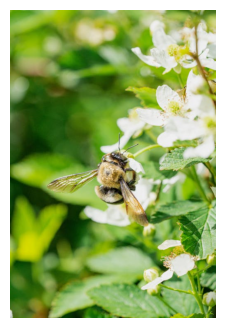

Predicted class: bee


In [4]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = 'https://images.pexels.com/photos/16368043/pexels-photo-16368043/free-photo-of-bee-collecting-nectar-and-pollinating-a-flower.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
image = Image.open(requests.get(url, stream=True).raw)

# Displaying the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off') 
plt.show()

# Processing and prediction
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# App UI

In [ ]:
!pip install gradio transformers torch pillow requests

In [37]:
import gradio as gr
from PIL import Image
import requests

# Updated CSS for better width control
custom_css = """
:root {
    --container-width: min(1400px, 95vw);
}
.gradio-container {
    background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
    max-width: var(--container-width) !important;
    margin: 0 auto !important;
    padding: 20px !important;
}
.header {
    text-align: center;
    padding: 20px;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    color: white;
    border-radius: 8px;
    margin-bottom: 20px;
    width: 100%;
}
h1, p {
    color: white;
    margin: 0;
}
.tab-button {
    background: white !important;
    padding: 12px 20px !important;
    border-radius: 8px !important;
    font-weight: 500 !important;
}
.tab-button.selected {
    background: #667eea !important;
    color: white !important;
}
.image-container {
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.1);
    overflow: hidden;
    height: 450px;
    width: 100%;
    display: flex !important;
    justify-content: center;
    align-items: center;
    background: #f8f9fa;
}
.image-container img {
    max-height: 100%;
    max-width: 100%;
    object-fit: contain;
    border-radius: 8px;
}
.prediction-box {
    background: white;
    padding: 20px;
    border-radius: 8px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    font-size: 1.2em;
    min-height: 80px;
    width: 100%;
}
.example-image {
    border-radius: 8px;
    margin: 8px;
    cursor: pointer;
    transition: transform 0.2s;
    height: 140px !important;
    width: auto !important;
    object-fit: cover;
}
.example-image:hover {
    transform: scale(1.05);
}
.column {
    gap: 25px !important;
}
.tabs {
    width: 100% !important;
}
.tab-content {
    padding: 20px 0 !important;
}
"""

def classify_image(image):
    """Process image and return prediction"""
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    prediction = model.config.id2label[outputs.logits.argmax(-1).item()]
    return image, f"✨ {prediction} ✨"

def load_from_url(url):
    """Fetch image from URL"""
    try:
        img = Image.open(requests.get(url, stream=True).raw)
        if max(img.size) > 1000:
            img.thumbnail((1000, 1000), Image.LANCZOS)
        return img
    except Exception as e:
        raise gr.Error(f"🚨 Failed to load image: {str(e)}")

with gr.Blocks(theme=gr.themes.Soft(), css=custom_css) as demo:
    # Header with title
    gr.Markdown("""
    <div class="header">
        <h1>Image Classifier</h1>
        <p>Upload an image or paste a URL to identify its content</p>
    </div>
    """)
    
    with gr.Tabs():
        # Tab 1: Upload Image
        with gr.Tab("📤 Upload Image", elem_classes="tab-button"):
            with gr.Row(equal_height=True):
                with gr.Column(scale=1):
                    upload = gr.Image(type="pil", label="🖼️ Drag image here")
                    upload_btn = gr.Button("🔍 Classify", variant="primary", size="lg")
                with gr.Column(scale=1):
                    with gr.Column(elem_classes="image-container"):
                        upload_output = gr.Image(show_label=False)
                    upload_result = gr.Label(label="📝 Prediction", elem_classes="prediction-box")
            
            upload_btn.click(
                classify_image,
                inputs=upload,
                outputs=[upload_output, upload_result]
            )
        
        # Tab 2: Image URL
        with gr.Tab("🌐 Image URL", elem_classes="tab-button"):
            with gr.Row(equal_height=True):
                with gr.Column(scale=1):
                    url = gr.Textbox(label="🔗 Paste image URL here", 
                                   placeholder="https://example.com/image.jpg")
                    url_btn = gr.Button("🔍 Classify", variant="primary", size="lg")
                    
                    with gr.Accordion("💡 Try these examples:", open=False):
                        gr.Examples(
                            examples=[
                                ["https://images.pexels.com/photos/16368043/pexels-photo-16368043.jpeg"],
                                ["https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"],
                                ["https://images.pexels.com/photos/1266810/pexels-photo-1266810.jpeg"],
                                ["https://images.pexels.com/photos/769525/pexels-photo-769525.jpeg"]
                            ],
                            inputs=url,
                            examples_per_page=2,
                            label=""
                        )
                with gr.Column(scale=1):
                    with gr.Column(elem_classes="image-container"):
                        url_output = gr.Image(show_label=False)
                    url_result = gr.Label(label="📝 Prediction", elem_classes="prediction-box")
            
            url_btn.click(
                load_from_url,
                inputs=url,
                outputs=url_output
            ).then(
                classify_image,
                inputs=url_output,
                outputs=[url_output, url_result]
            )

    gr.Markdown("""
    <div style="text-align: center; margin-top: 20px; color: #666;">
        <p>Powered by Vision Transformer (ViT) | Made with Gradio</p>
    </div>
    """)

demo.launch()

* Running on local URL:  http://127.0.0.1:7888
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6fdb755ab44d385289.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
